## Predicting using Deployed Cnvrg Model
Once the model has been served using cnvrg's serving feature, images can be sent and inferenced through an API exposed by cnvrg

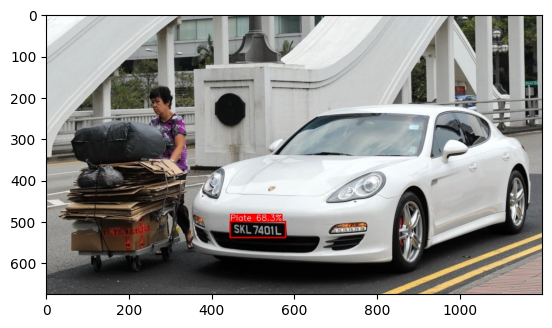

In [1]:
import http.client
import requests
import json
import base64
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
%matplotlib inline



image = cv2.imread("test-images/06.jpg")
jpg_as_text = base64.b64encode(cv2.imencode('.jpg', image)[1]).decode()

conn = http.client.HTTPSConnection("predict-lp-gpu-1.mlops.cnasg.dellcsc.com", 443)

# payload = "{\"input_params\": \"" + image.tostring() + "\"}"

payload = {
    'input_params': jpg_as_text
}

headers = {
    'Cnvrg-Api-Key': "Y42BVQjkCW29XN7NsWrLuFSr",
    'Content-Type': "application/json"
    }


conn.request("POST", "/api/v1/endpoints/wirjudesd7xzvppzuqdy", json.dumps(payload), headers)

res = conn.getresponse()
data = res.read()
data_formatted = json.loads(data.decode("utf-8"))
pred_image_encoded = data_formatted['prediction']
pred_image = base64.b64decode(pred_image_encoded)
pred_image_np = np.frombuffer(pred_image, dtype=np.uint8)
# img = cv2.cvtColor(cv2.imdecode(pred_image_np, flags=1), cv2.COLOR_BGR2RGB)
img = cv2.imdecode(pred_image_np, flags=1)

plt.imshow(img)
plt.show()
# print(data.decode("utf-8"))

# Predict using locally-stored model


0: 448x640 1 License Plate, 226.7ms
Speed: 5.0ms preprocess, 226.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.7366)
192 357 477 526


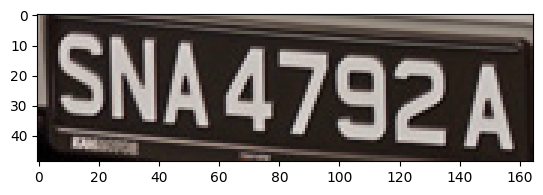

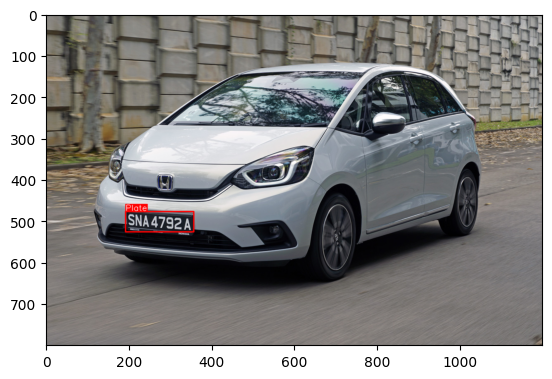

In [76]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.00001), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  
  # extract cartesian coordinates, crop image, and make a copy
  x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
  roi = image[y1:y2, x1:x2].copy()
  print(x1, x2, y1, y2)
  plt.imshow(roi)
  plt.show()

  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
    if labels == []:
        labels = {0: u'__background__', 1: u'Plate'}
    #Define colors
    if colors == []:
        # NOTE: opencv uses the BGR format instead of RGB
        colors = [(0, 0, 255), (253, 246, 160), (40, 132, 70)]
                  
    #plot each boxes
    for box in boxes:
        #add score in label if score=True
        if score:
            label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
        else:
            label = labels[int(box[-1])+1]
        #filter every box under conf threshold if conf threshold setted
        if conf:
            print(box[-2])
            if box[-2] > conf:
                color = colors[int(box[-1])]
                box_label(image, box, label, color)
            # else:
            #     color = colors[int(box[-1])]
            #     box_label(image, box, label, color)
        
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


images = []
# image = Image.open("test-images/02.jpg")
# image = np.asarray(image)
image = cv2.imread("test-images/07.jpg")
images.append(image)

device = '0' if torch.cuda.is_available() else 'cpu'

# model = YOLO('runs/detect/train_ori/weights/best.pt')  # load a custom model
model = YOLO('output/train/weights/last.pt')  # load a custom model
results = model.predict(images, device=device)
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Class probabilities for classification outputs
    # print(boxes.data)
    pred = plot_bboxes(image, boxes.data, conf=0.25, score=False)
    plt.imshow(pred)
    plt.show()

